# Neural compression with Jaxili

In this notebook we demonstrate how to perform a neural compression using jaxili. The goal of the compression is to decrease the dimension of $x$ without information loss. Here we demonstrate two ways of doing the compression:
- A suboptimal but intuitive way, where the compressed vector $t$ is an estimation of the parameters $\theta$. The loss funstion used here is a mean squared error. We call this method `MSE`
- A Variational Mutual Information Maximization (`VMIM`) technique that maximizes the Kullback-Leibler divergence $D_{KL} (p(t, θ)\|p(t)p(θ))$ 

In [ ]:
import os

import jax
import jax.numpy as jnp
import numpy as np

from jaxili.compressor import MLPCompressor
from jaxili.compressor import Compressor
from jaxili.inference import NPE
from jaxili.validation import get_tarp_coverage
import flax.linen as nn

import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline


print("Device used by jax:", jax.devices())

Device used by jax: [CpuDevice(id=0)]


# Generating dataset

We use a simple linear gaussian example to illustrate the method, where the dimension of the simulations $x$ has been artificially modified. For each $\theta$, we have $n_{reals}$ simulations, so that for a given $\theta$ the dimension of $x$ is $n_{dim} \times n_{reals}$

In [2]:
master_key = jax.random.PRNGKey(0)

num_samples = 10_000
n_dim = 3
n_reals = 11

In [3]:

def simulator(theta, rng_key):
    batch_size = theta.shape[0]
    return (theta[..., None] + jax.random.normal(rng_key, shape=(batch_size, n_dim, n_reals))*0.1).reshape(batch_size, n_dim*n_reals)

def get_x_theta(rng_key):
    num_samples = 10_000

    theta_key, rng_key = jax.random.split(rng_key)
    theta = jax.random.uniform(theta_key, shape=(num_samples, n_dim), minval=jnp.array([-2., -2., -2.]), maxval=jnp.array([2., 2., 2.]))

    sim_key, rng_key = jax.random.split(rng_key)
    x = simulator(theta, sim_key)
    return x, theta

In [4]:
simulation_key, master_key = jax.random.split(master_key)
x, theta = get_x_theta(simulation_key)

print("Parameters shape:", theta.shape)
print("Data shape:", x.shape)

Parameters shape: (10000, 3)
Data shape: (10000, 33)


# Defining the compressor model

We use the same architecture for the `MSE` and `VMIM`

In [5]:
model_class=MLPCompressor

model_hparams={
    'hidden_size': [8, 4],
    'activation': nn.relu,
    'output_size': n_dim,
}

# MSE compression

To perform the MSE compression, we use the `Compressor` class of `jaxili`

In [6]:
compressor = Compressor(
    model_class=model_class,
    model_hparams=model_hparams,
)

compressor = compressor.append_simulations(theta=theta, x=x)

metrics, MSE_compression_function = compressor.train(
    checkpoint_path=os.path.abspath("."),
    num_epochs=500,
)

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.
[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.

                             MLPCompressor Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module        ┃ inputs        ┃ outputs      ┃ params              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLPCompressor │ float32[1,33] │ float32[1,3] │                     │
├─────────┼───────────────┼───────────────┼──────────────┼─────────────────────┤
│ Dense_0 │ Dense         │ float32[1,33] │ float32[1,8] │ bias: float32[8]    │
│         │               │               │              │ kernel:             │
│    

Epochs: Val loss 0.001/ Best val loss 0.002:  12%|█▏        | 58/500 [00:10<01:21,  5.39it/s]


Neural network training stopped after 59 epochs.
Early stopping with best validation metric: 0.0019897730089724064
Best model saved at epoch 59
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: 0.0013131293235346675
[!] Validation loss: 0.0013107905397191644
[!] Test loss: 0.0013330494984984398


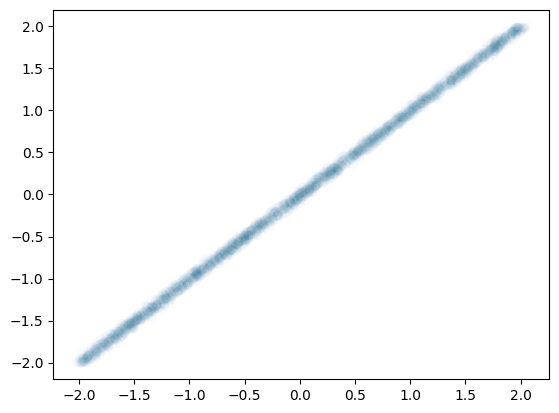

In [7]:
theta_test, x_test = compressor._test_dataset.arrays
t_test = MSE_compression_function(x_test)
plt.scatter(t_test, theta_test, alpha = .01)
plt.show()

# VMIM compression

To perform the VMIM compression we use a `NPE` with an embedding network that corresponds to our compressor.

In [8]:
VMIM = NPE()
VMIM = VMIM.append_simulations(theta=theta, x=x)

metrics_VMIM, density_estimator = VMIM.train(
    checkpoint_path=os.path.abspath("."),
    num_epochs=500,
    embedding_net=model_class,
    embedding_hparams=model_hparams,
)

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.
[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 
[!] Training the density estimator.


Epochs: Val loss -5.951/ Best val loss -5.956:  53%|█████▎    | 266/500 [01:20<01:11,  3.29it/s]


Neural network training stopped after 267 epochs.
Early stopping with best validation metric: -5.955786228179932
Best model saved at epoch 261
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: -6.019770622253418
[!] Validation loss: -5.956381797790527
[!] Test loss: -5.902978420257568


The compressor function is the embedding network of the NPE:

In [9]:
VMIM_compression_function = density_estimator.embedding_net

# Inference

In order to do the inference let's first draw new simulations and create an observation

In [10]:
# Creating new simulations for the inference

simulation_key, master_key = jax.random.split(master_key)
x, theta = get_x_theta(simulation_key)

print("Parameters shape:", theta.shape)
print("Data shape:", x.shape)

Parameters shape: (10000, 3)
Data shape: (10000, 33)


In [11]:
obs_key, master_key = jax.random.split(master_key)
fiducial = jnp.array([[0.5, 0.5, 0.5]])
x_obs = simulator(fiducial, obs_key)

## MSE Inference

We perform the inference the usual way:

In [12]:
MSE_t = MSE_compression_function(x)

inference = NPE()
inference = inference.append_simulations(theta, MSE_t)
metrics, density_estimator = inference.train(
    checkpoint_path=os.path.abspath("."),
    num_epochs=500,
)
MSE_posterior = inference.build_posterior()

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.
[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 
[!] Training the density estimator.


Epochs: Val loss -5.570/ Best val loss -5.692:  12%|█▏        | 58/500 [00:18<02:20,  3.14it/s]


Neural network training stopped after 59 epochs.
Early stopping with best validation metric: -5.691863536834717
Best model saved at epoch 38
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: -5.599943161010742
[!] Validation loss: -5.691863536834717
[!] Test loss: -5.7110419273376465
[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [13]:
t_obs = MSE_compression_function(x_obs)
num_samples = 10_000
sample_key, master_key = jax.random.split(master_key)
samples = MSE_posterior.sample(
    x=t_obs, num_samples=num_samples, key=sample_key
)

Removed no burn in


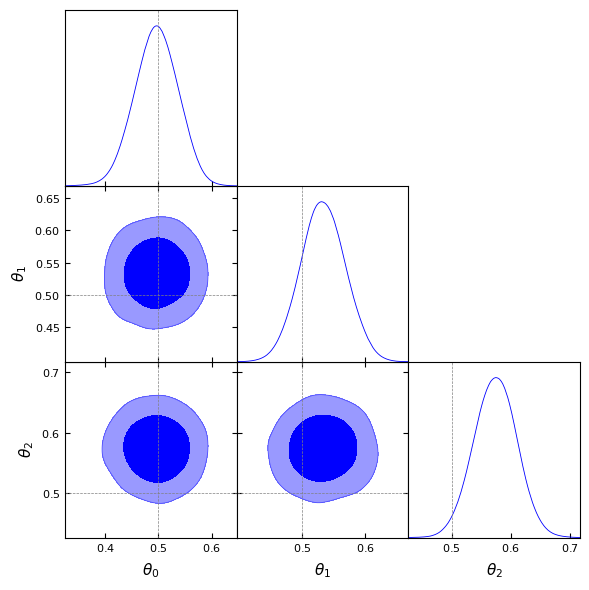

In [14]:
labels = [rf'\theta_{i}' for i in range(n_dim)]
samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4
g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

## VMIM Inference

In [15]:
VMIM_t = VMIM_compression_function(x)

inference = NPE()
inference = inference.append_simulations(theta, VMIM_t)
metrics, density_estimator = inference.train(
    checkpoint_path=os.path.abspath("."),
    num_epochs=500,
)
VMIM_posterior = inference.build_posterior()

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.
[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 
[!] Training the density estimator.


Epochs: Val loss -5.985/ Best val loss -5.990:  55%|█████▍    | 274/500 [01:20<01:06,  3.39it/s]


Neural network training stopped after 275 epochs.
Early stopping with best validation metric: -5.9898176193237305
Best model saved at epoch 254
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: -6.070208549499512
[!] Validation loss: -5.9898176193237305
[!] Test loss: -5.934837341308594
[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [16]:
t_obs = VMIM_compression_function(x_obs)
num_samples = 10_000
sample_key, master_key = jax.random.split(master_key)
samples = VMIM_posterior.sample(
    x=t_obs, num_samples=num_samples, key=sample_key
)

Removed no burn in


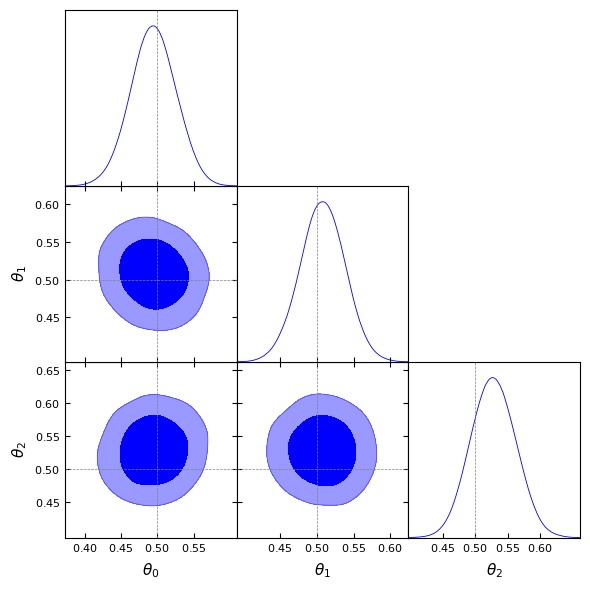

In [17]:
labels = [rf'\theta_{i}' for i in range(n_dim)]
samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4
g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })
                
plt.show()

## TARP coverage check

We can now check the coverage with the function `get_tarp_coverage` from `jaxili`

In [18]:
# new simulations

num_samples = 10_000

theta_key, master_key = jax.random.split(master_key)
theta = jax.random.uniform(theta_key, shape=(num_samples, n_dim), minval=jnp.array([-2., -2., -2.]), maxval=jnp.array([2., 2., 2.]))

sim_key, master_key = jax.random.split(master_key)
x = simulator(theta, sim_key)

Computing TARP coverage...


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


Computing TARP coverage...


100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


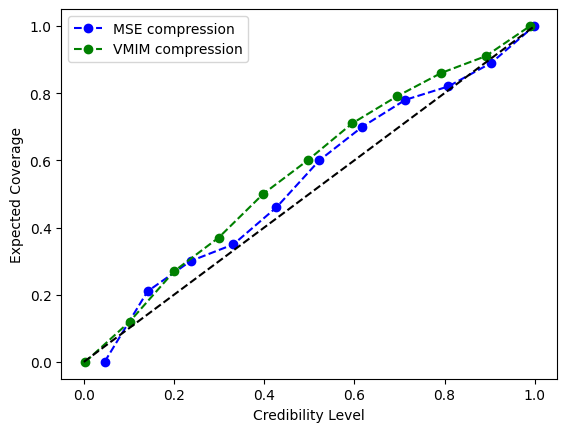

In [19]:
MSE_t = MSE_compression_function(x)
sample, master_key = jax.random.split(master_key)
MSE_coverage = get_tarp_coverage(posterior=MSE_posterior, theta_test=theta, x_test=MSE_t, key=sample_key)

VMIM_t = VMIM_compression_function(x)
sample, master_key = jax.random.split(master_key)
VMIM_coverage = get_tarp_coverage(posterior=VMIM_posterior, theta_test=theta, x_test=VMIM_t, key=sample_key)

plt.plot(MSE_coverage[1], MSE_coverage[0], 'o--', color='blue', label='MSE compression')
plt.plot(VMIM_coverage[1], VMIM_coverage[0], 'o--', color='green', label='VMIM compression')

plt.xlabel('Credibility Level')
plt.ylabel('Expected Coverage')
plt.legend()

plt.plot([0,1], [0,1], 'k--')
plt.show()